In [29]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
from util_datasets import GaussianNoise, UniformNoise
import csv
from tqdm import tqdm


from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

%load_ext autoreload

%autoreload 2


use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")


class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

imgtransResize = (320, 320)
imgtransCrop = 224

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

In [11]:
from chexpertClass import *
chex_datasetValid = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/valid.csv' ,transformSequence, preload = True, policy="ones")
chex_datasetTrain = CheXpertData('datasets/chexpert-small/CheXpert-v1.0-small/train.csv' ,transformSequence, policy="ones")
datasetTest, datasetTrain = random_split(chex_datasetTrain, [766, len(chex_datasetTrain) - 766])
chex_dataset = torch.utils.data.ConcatDataset([chex_datasetValid, datasetTest])
print(len(chex_dataset))

1000


In [12]:
dataLoaderChex = DataLoader(dataset=chex_dataset, batch_size=64, shuffle=True,  num_workers=1, pin_memory=True)
# dataiter = iter(dataLoaderChex)
# images, labels = dataiter.next()

In [13]:
len(dataLoaderChex.dataset)

1000

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#functions to show an image
# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
# imshow(torchvision.utils.make_grid(images))

In [15]:
nih_dataset = datasets.ImageFolder(root='datasets/nih-small/small', transform = transformSequence)
nih_test, nih_train = random_split(nih_dataset, [1000, len(nih_dataset) - 1000])
print(len(nih_test))
print(len(nih_train))

1000
4606


In [16]:
dataLoaderNIH = DataLoader(dataset=nih_test, batch_size=64, shuffle=False,  num_workers=1, pin_memory=True)

# Create DenseNet121

In [17]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [18]:
def test(model, use_cuda, dataLoaderSet, class_names):
    if use_cuda:
            outGT = torch.FloatTensor().to(device)
            outPRED = torch.FloatTensor().to(device)
    else:
        outGT = torch.FloatTensor()
        outPRED = torch.FloatTensor()
       
    model.eval()
        
    with torch.no_grad():
        for i, (data, target) in enumerate(dataLoaderSet):
            target = torch.stack(target).float().transpose(0,1)
            print(target.shape)
            outGT = torch.cat((outGT, target), 0).to(device)

            bs, c, h, w = data.size()
            varInput = data.view(-1, c, h, w)

            out = model(varInput)
            outPRED = torch.cat((outPRED, out), 0)
    aurocIndividual = computeAUROC(outGT, outPRED, len(class_names))
    aurocMean = np.array(aurocIndividual).mean()

    print ('AUROC mean ', aurocMean)

    for i in range (0, len(aurocIndividual)):
        print (class_names[i], ' ', aurocIndividual[i])

    return outGT, outPRED

In [19]:
num_classes = len(class_names)
model = DenseNet121(num_classes).to(device)
model = torch.nn.DataParallel(model).to(device)

In [21]:
def load_checkpoint(checkpoint_path, model, optimizer, use_cuda):
    if use_cuda:
        state = torch.load(checkpoint_path)
    else:
        state = torch.load(checkpoint_path, map_location='cpu')
    
    state_dict = state['state_dict']
    optim_dict = state['optimizer']
    
    model.load_state_dict(state_dict)
    optimizer.load_state_dict(optim_dict)
    
    print('model loaded from %s' % checkpoint_path)

In [22]:
checkpoint_path = 'cheXpert_github/model_ones_3epoch_densenet.tar'
optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
load_checkpoint(checkpoint_path, model, optimizer, use_cuda)

model loaded from cheXpert_github/model_ones_3epoch_densenet.tar


In [23]:
def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC

In [24]:
outGT1, outPRED1 = test(model, use_cuda, dataLoaderChex, class_names)

torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([64, 14])
torch.Size([40, 14])
AUROC mean  0.7644098993637816
No Finding   0.8486810319837667
Enlarged Cardiomediastinum   0.5647718042440857
Cardiomegaly   0.7921223031247481
Lung Opacity   0.7453878822083728
Lung Lesion   0.6742502585315407
Edema   0.850131060594448
Consolidation   0.703461508616737
Pneumonia   0.7476126781041
Atelectasis   0.7026288030202088
Pneumothorax   0.7282486490407283
Pleural Effusion   0.847456698323575
Pleural Other   0.8486625575967925
Fracture   0.7780416514431859
Support Devices   0.8702817042606517


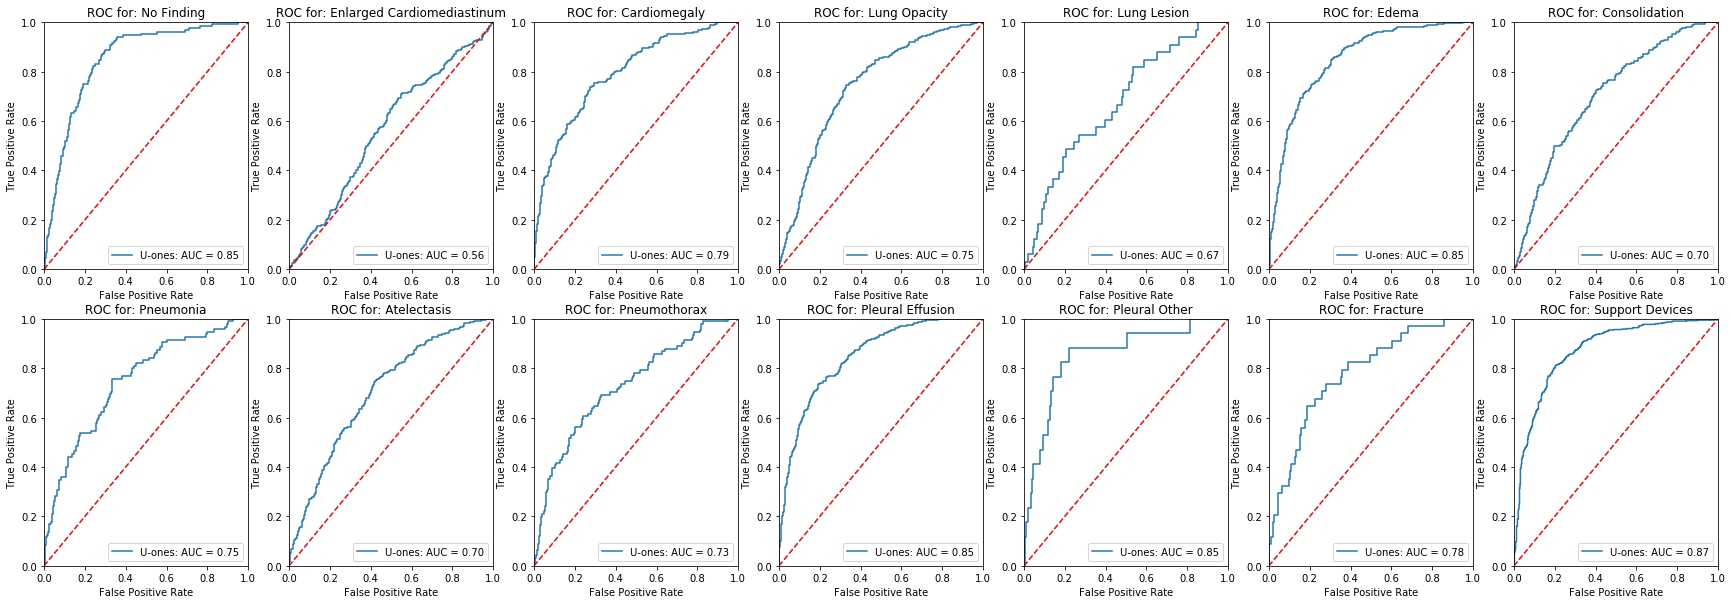

In [26]:
##PLOT AUC RESULTS
for i in range(len(class_names)):
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    #fpr2, tpr2, threshold2 = metrics.roc_curve(outGT3.cpu()[:,i], outPRED3.cpu()[:,i])
    #roc_auc2 = metrics.auc(fpr2, tpr2)
    #fpr3, tpr3, threshold2 = metrics.roc_curve(outGT4.cpu()[:,i], outPRED4.cpu()[:,i])
    #roc_auc3 = metrics.auc(fpr3, tpr3)


    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    #plt.plot(fpr2, tpr2, label = 'U-zeros: AUC = %0.2f' % roc_auc2)
    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.savefig("ROC1345.png", dpi=1000)
plt.show()

# EVALUATION AND TEST WITH BASELINE

In [33]:
def evaluate_ood(data_loader, model):
    model.eval()
    outPred = []
    outGround = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader)
        for i, (images,labels) in enumerate(progress_bar):
            if type(labels) == list:
                labels = torch.stack(labels).float().transpose(0,1)

            bs, c, h, w = images.size()
            varInput = images.view(-1, c, h, w)
            
            outGround.append(labels)
            pred = model(varInput)
            pred = pred.cpu().numpy()
            outPred.append(pred)

    outPred = np.concatenate(outPred)
    outGround = np.concatenate(outGround)
    return outPred, outGround



In [35]:
def tpr76(ind_confidences, ood_confidences):
    #calculate the falsepositive error when tpr is 75-76%
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / 100000

    total = 1.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        #if tpr <= 0.9505 and tpr >= 0.9495:
        if tpr <= 0.7605 and tpr >= 0.7495:
            fpr += error2
            total += 1

    fprBase = fpr / total

    return fprBase


def detection(ind_confidences, ood_confidences, n_iter=100000, return_data=False):
    # calculate the minimum detection error
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / n_iter

    best_error = 1.0
    best_delta = None
    all_thresholds = []
    all_errors = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        detection_error = (tpr + error2) / 2.0

        if return_data:
            all_thresholds.append(delta)
            all_errors.append(detection_error)

        if detection_error < best_error:
            best_error = np.minimum(best_error, detection_error)
            best_delta = delta

    if return_data:
        return best_error, best_delta, all_errors, all_thresholds
    else:
        return best_error, best_delta

In [36]:
#ind_scores, ind_gt = evaluate_ood(dataLoaderChex, 'baseline',model)
ood_scores, _ = evaluate_ood(dataLoaderNIH, model)


100%|██████████| 16/16 [09:42<00:00, 32.49s/it]

In [42]:
ind_gt, ind_scores = outGT1.cpu().numpy(), outPRED1.cpu().numpy()

In [43]:
#this cell is to double check auroc values
for i in range (0, len(class_names)):
    try:
        auc = metrics.roc_auc_score(ind_gt[:,i],ind_scores[:,i])
        print (class_names[i], ' ', auc)
    except ValueError:
        pass

No Finding   0.8486810319837667
Enlarged Cardiomediastinum   0.5647718042440857
Cardiomegaly   0.7921223031247481
Lung Opacity   0.7453878822083728
Lung Lesion   0.6742502585315407
Edema   0.850131060594448
Consolidation   0.703461508616737
Pneumonia   0.7476126781041
Atelectasis   0.7026288030202088
Pneumothorax   0.7282486490407283
Pleural Effusion   0.847456698323575
Pleural Other   0.8486625575967925
Fracture   0.7780416514431859
Support Devices   0.8702817042606517


In [75]:
ind_conf = ind_gt * ind_scores
ood_conf = ind_gt * ood_scores
ind_conf = np.sum(ind_conf, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)
ood_conf = np.sum(ood_conf, axis = 1) / (np.sum(ind_gt, axis = 1) + 1e-10)

In [79]:
ood_labels = np.zeros((ood_conf.shape[0]))
ind_labels = np.ones((ind_conf.shape[0]))
labels = np.concatenate([ind_labels, ood_labels])
scores = np.concatenate([ind_conf,ood_conf])
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}


stat['fpr_at_76_tpr'] = tpr76(ind_conf, ood_conf)
stat['detection_error'], stat['best_delta'] = detection(ind_conf, ood_conf)
#try:
metric['auroc'] = metrics.roc_auc_score(labels, scores)
metric['aupr_in'] = metrics.average_precision_score(labels, scores)
metric['aupr_out'] = metrics.average_precision_score(-1 * labels + 1, 1 - scores)
#except ValueError:
#    pass


Method: baseline
TPR75 (lower is better):  0.3365351458885985
Detection error (lower is better):  0.28400000000000003
Best threshold: 0.30312173555672167
AUROC (higher is better):  0.765227
AUPR_IN (higher is better):  0.7412182321975384
AUPR_OUT (higher is better):  0.7254260190515711


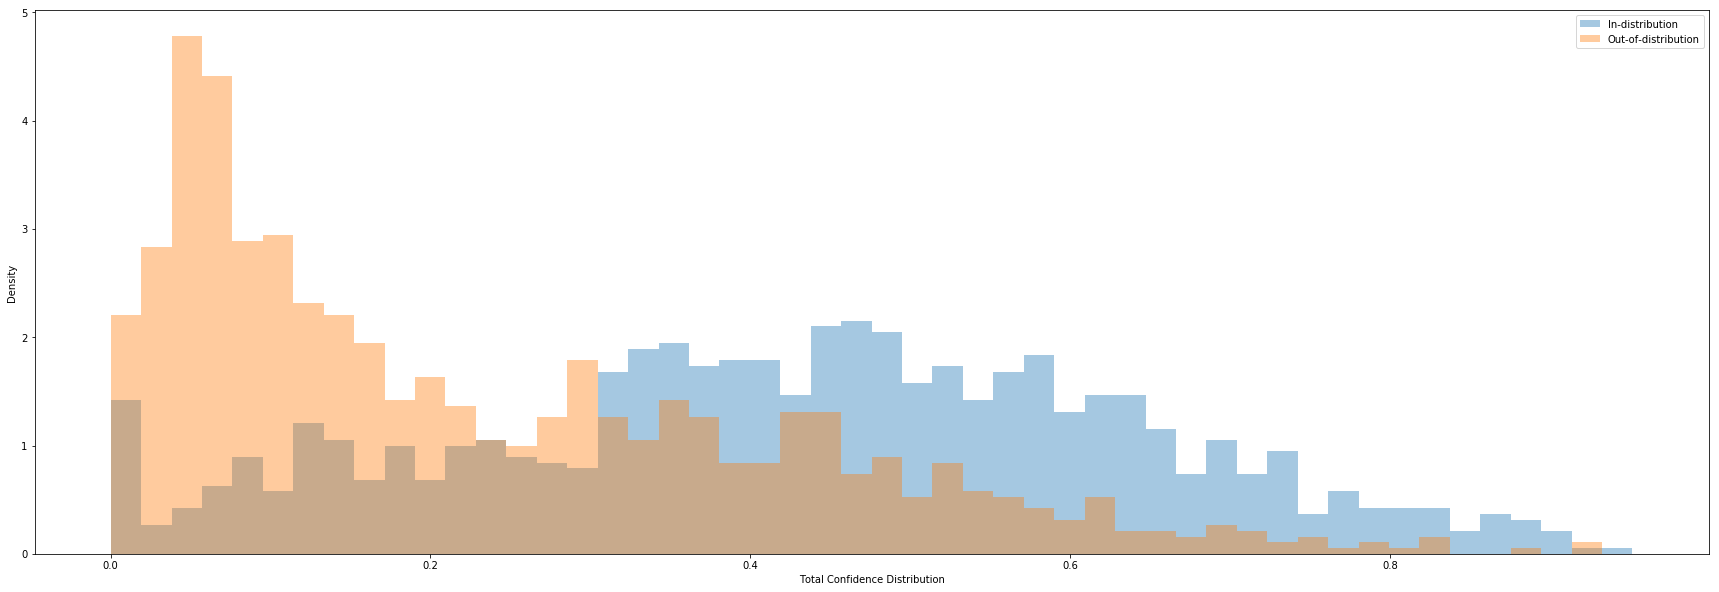

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
print("")
print("Method: baseline")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])
        
ranges = (np.min(scores), np.max(scores))
sns.distplot(ind_conf.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
sns.distplot(ood_conf.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
ood_gt = np.zeros((ood_scores.shape[0], ood_scores.shape[1]))
labels = np.concatenate([ind_gt, ood_gt])
scores = np.concatenate([ind_scores, ood_scores])

In [21]:
numClasses = 14
stat = {
    'fpr_at_76_tpr' : 0,
    'detection_error' : 0,
    'best_delta' : 0,
}
st_cnt = 0

metric = {
    'auroc' : 0,
    'aupr_in' : 0,
    'aupr_out' : 0,
}
met_cnt = 0

for i in range(numClasses):
    mask = ind_gt[:,i] == 1
    ind = ind_scores[:,i][mask]
    ood = ood_scores[:,i][mask]
    print(ind.size)
    if ind.size != 0:
        stat['fpr_at_76_tpr'] += tpr76(ind, ood)
        detection_error, best_delta = detection(ind, ood)
        stat['detection_error'] += detection_error
        stat['best_delta'] += best_delta
        st_cnt += 1
    try:
        metric['auroc'] += metrics.roc_auc_score(labels[:,i], scores[:,i])
        metric['aupr_in'] += metrics.average_precision_score(labels[:,i], scores[:,i])
        metric['aupr_out'] += metrics.average_precision_score(-1 * labels[:,i] + 1, 1 - scores[:,i])
        met_cnt += 1
    except ValueError:
        pass

stat = {k: v / st_cnt for k, v in stat.items()}
metric = {k: v / met_cnt for k, v in metric.items()}

75
158
138
398
24
218
129
74
252
63
300
10
27
357



Method: baseline
TPR75 (lower is better):  0.267505018526628
Detection error (lower is better):  0.2584571825092875
Best threshold: 0.16860760623429893
AUROC (higher is better):  0.7659836828994325
AUPR_IN (higher is better):  0.2892957011757141
AUPR_OUT (higher is better):  0.9665890712237438


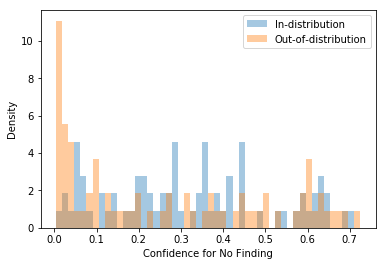

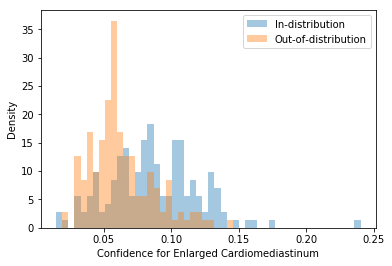

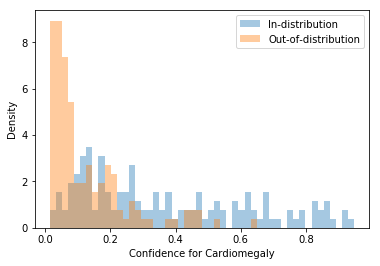

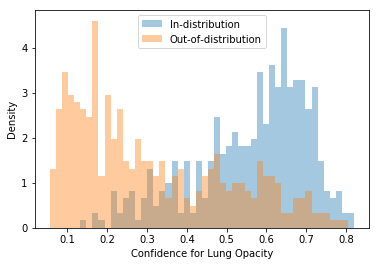

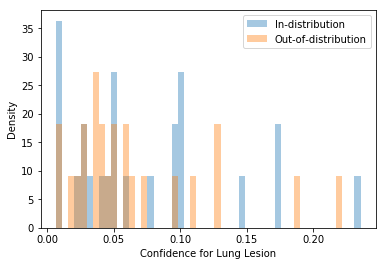

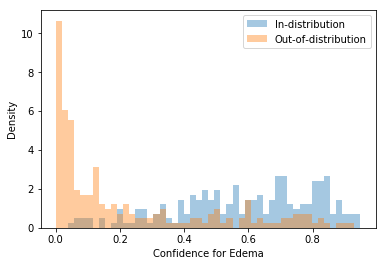

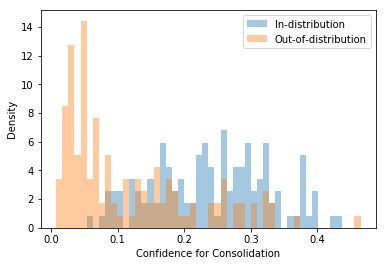

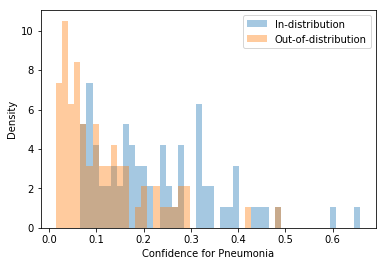

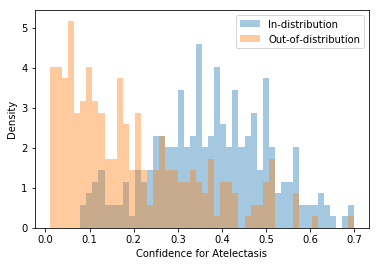

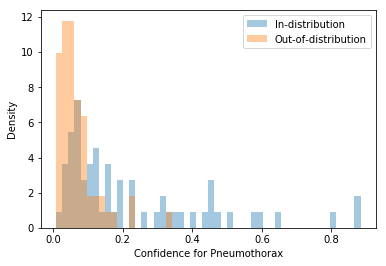

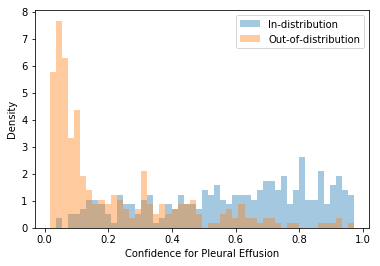

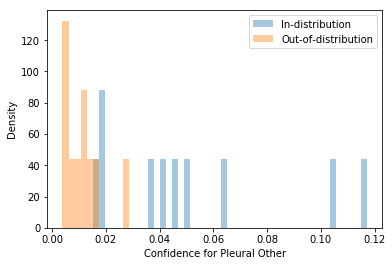

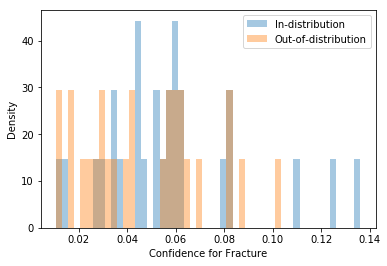

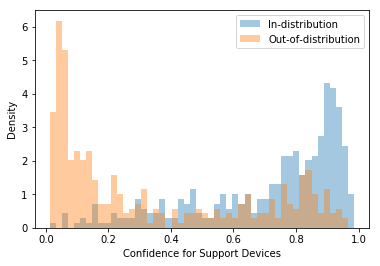

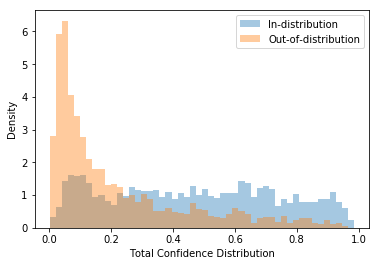

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
print("")
print("Method: baseline")
print("TPR75 (lower is better): ", stat['fpr_at_76_tpr'])
print("Detection error (lower is better): ", stat['detection_error'])
print("Best threshold:", stat['best_delta'])
print("AUROC (higher is better): ", metric['auroc'])
print("AUPR_IN (higher is better): ", metric['aupr_in'])
print("AUPR_OUT (higher is better): ", metric['aupr_out'])
total_ind_scores = []
total_ood_scores = []
for i in range(14):
    #mask = ind_scores[:,i] > 0.5
    mask = ind_gt[:,i] == 1
    ind = ind_scores[:,i][mask]
    ood = ood_scores[:,i][mask]
    total_ind_scores.append(ind)
    total_ood_scores.append(ood)
    all_scores = np.concatenate([ind, ood])
    if all_scores.size != 0:
        ranges = (np.min(all_scores), np.max(all_scores))
        plt.figure()
        sns.distplot(ind.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
        sns.distplot(ood.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
        plt.xlabel('Confidence for ' + class_names[i])
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        
total_ind_scores = np.concatenate(total_ind_scores)
total_ood_scores = np.concatenate(total_ood_scores)
all_scores = np.concatenate([total_ind_scores, total_ood_scores])
ranges = (np.min(all_scores), np.max(all_scores))
sns.distplot(total_ind_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
sns.distplot(total_ood_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
plt.xlabel('Total Confidence Distribution')
plt.ylabel('Density')
plt.legend()
plt.show()